# Galaxy Image Classification - Baseline Model

This model was created to offer astronomers additional help in classifying galaxies so they don't have to manually look at all the photographic plates. Most models out there offer high accuracies but may not be the easiest to implement, I will try to make a user friendly model. 

### Column Descriptions

**training_predictions**: Probability distributions for the classifications for each of the training images.

**images_test**: JPG images of 79975 galaxies. Files are name according to their GalaxyId. You will provide probabilities for each of these images. (I don't use this)

**images_train**: JPG images of 61578 galaxies. Files are named according to their GalaxyId.

### Importing Libraries

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm #displays progress bar within for loops
import matplotlib.pyplot as plt
from skimage import io
import pickle
from skimage.transform import resize
import glob
import os
%matplotlib inline 
import warnings
warnings.filterwarnings('ignore')

### Size of all images

```python
size = set()
for filename in glob.glob('data/*.jpg'): 
    im=io.imread(filename).shape
    size.add(im)``` 

size for all images are: {(424, 424, 3)}

### Visualize the predictions

In [ ]:
import pandas as pd
import numpy as np

predictions = pd.read_csv('predictions.csv')
predictions.head()

There seems to be ambigious headings for our columns and the resources on Kaggle don't seem to help much. Essentially, the classes refer to the morphology on the galaxy. 

In [ ]:
(predictions['Class1.1'] + predictions['Class1.2'] + predictions['Class1.3']).head()

In [ ]:
predictions = predictions[['GalaxyID','Class1.1', 'Class1.2', 'Class1.3']]
predictions.head(10)

Based on the images printed above, we can use our physics brain to determine what the columns stand for and rename the columns. 

In [ ]:
predictions.columns = ['GalaxyID', 'Elliptical', 'Spiral', 'Irregular']
predictions.head()

If the value in the irregular was the max value for that row, we called it an irregular. 

Note: The following code below no longer works because the irregular folders are deleted. 

```python
print('num in train elliptical = {}'.format(len(os.listdir('data/train/elliptical/'))))
print('num in train spiral = {}'.format(len(os.listdir('data/train/spiral/'))))
print('num in train irregular = {}'.format(len(os.listdir('data/train/irregular/'))))
print('num in test elliptical = {}'.format(len(os.listdir('data/test/elliptical/'))))
print('num in test spiral = {}'.format(len(os.listdir('data/test/spiral/'))))
print('num in test irregular = {}'.format(len(os.listdir('data/test/irregular/'))))```

num in train elliptical = 13237 <br>
num in train spiral = 17526 <br>
num in train irregular = 26 <br>
num in test elliptical = 13456 <br>
num in test spiral = 17300 <br>
num in test irregular = 33 <br>

For this, we can remove the irregular images since they make such a small portion of our over all dataset. 

Now, let's delete the irregular galaxies from the predictions (because we deleted their images). Then we will drop the "Irregular" column.

In [ ]:
len(predictions[(predictions.Irregular > predictions.Spiral) & (predictions.Irregular > predictions.Elliptical)])

In [ ]:
predictions[(predictions.Irregular > predictions.Spiral) & (predictions.Irregular > predictions.Elliptical)].head()

In [ ]:
predictions.drop(predictions[(predictions.Irregular > predictions.Spiral) & (predictions.Irregular > predictions.Elliptical)].index,inplace=True)

In [ ]:
predictions.drop(['Irregular'], axis=1, inplace=True)

In [ ]:
predictions.head()

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os, shutil
from keras import models
from keras import layers
from sklearn.metrics import confusion_matrix, f1_score
np.random.seed(123)
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


In [2]:
# get all the data in the directory split/test, and reshape them
datagen = ImageDataGenerator(validation_split=0.2,rescale=1./255)
data_tr=datagen.flow_from_directory( 
        'data/train', 
        target_size=(106, 106), #actual image size 
        batch_size = 32,
        subset='training',
        seed = 123)

data_val =datagen.flow_from_directory( 
        'data/train', 
        target_size=(106, 106), #actual image size 
        batch_size = 32,
        subset='validation',
        seed = 123)

Found 24611 images belonging to 2 classes.
Found 6152 images belonging to 2 classes.


In [3]:
data_te = ImageDataGenerator(rescale=1./255).flow_from_directory( 
        'data/test', 
        target_size=(106, 106), 
        batch_size = 32, 
        seed = 123) 

Found 30756 images belonging to 2 classes.


# Simple Neural Network -- Baseline

In [4]:
## initialize the model
from keras.models import Sequential, Input
from keras.layers import Dense
model = Sequential()

W0717 23:52:33.976216 4326028736 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



In [5]:
## prepare a placeholder for input
# this is our input placeholder
# inp = Input(shape=(212, 212,  3)) # here shape (212, 212,  3) means we specify only the number of rows but we can input as many columns as we would like


## Architecture

After flattening the images, we have a neural network with one hidden layer (128 neurons). The final, 2-neuron layer is our prediction layer.

In [6]:
## Adding layers --> simple as .add()
## Remember Dense means linear layer + activation
## after the first layer, you don't need to specify
model.add(layers.Flatten(input_shape=(106, 106,  3)))
layer_1 = model.add(Dense(units=128, activation='relu')) # --> output will be (128, )
layer_2 = model.add(Dense(units=2, activation='softmax'))# --> output will be (2, )

W0717 23:52:33.996934 4326028736 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0717 23:52:34.010070 4326028736 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [7]:
# Option I - gradient descent
model.compile(loss='mean_squared_error',
              optimizer='sgd',
              metrics=['mae', 'acc'])

W0717 23:52:34.045701 4326028736 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [8]:
# Training the model!
history = model.fit_generator(data_tr,
                    epochs=50,
                    validation_data=data_val,
                    steps_per_epoch=50,
                    validation_steps=50)

W0717 23:52:34.246652 4326028736 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0717 23:52:34.259459 4326028736 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Epoch 1/50
50/50 [==============================] - 8s 151ms/step - loss: 0.2410 - mean_absolute_error: 0.4866 - acc: 0.5800 - val_loss: 0.2346 - val_mean_absolute_error: 0.4792 - val_acc: 0.5975
Epoch 2/50
50/50 [==============================] - 7s 133ms/step - loss: 0.2324 - mean_absolute_error: 0.4761 - acc: 0.6419 - val_loss: 0.2247 - val_mean_absolute_error: 0.4674 - val_acc: 0.6462
Epoch 3/50
50/50 [==============================] - 7s 150ms/step - loss: 0.2258 - mean_absolute_error: 0.4664 - acc: 0.6519 - val_loss: 0.2281 - val_mean_absolute_error: 0.4696 - val_acc: 0.6613
Epoch 4/50
50/50 [==============================] - 8s 156ms/step - loss: 0.2163 - mean_absolute_error: 0.4518 - acc: 0.6750 - val_loss: 0.2177 - val_mean_absolute_error: 0.4458 - val_acc: 0.6491
Epoch 5/50
50/50 [==============================] - 7s 145ms/step - loss: 0.2127 - mean_absolute_error: 0.4441 - acc: 0.6950 - val_loss: 0.2111 - val_mean_absolute_error: 0.4426 - val_acc: 0.6881
Epoch 6/50
50/50 [==

Epoch 43/50
50/50 [==============================] - 6s 119ms/step - loss: 0.1831 - mean_absolute_error: 0.3836 - acc: 0.7631 - val_loss: 0.1859 - val_mean_absolute_error: 0.3881 - val_acc: 0.7449
Epoch 44/50
50/50 [==============================] - 6s 118ms/step - loss: 0.1813 - mean_absolute_error: 0.3802 - acc: 0.7450 - val_loss: 0.1811 - val_mean_absolute_error: 0.3827 - val_acc: 0.7556
Epoch 45/50
50/50 [==============================] - 6s 118ms/step - loss: 0.1755 - mean_absolute_error: 0.3719 - acc: 0.7662 - val_loss: 0.1753 - val_mean_absolute_error: 0.3710 - val_acc: 0.7575
Epoch 46/50
50/50 [==============================] - 6s 119ms/step - loss: 0.1803 - mean_absolute_error: 0.3784 - acc: 0.7488 - val_loss: 0.1798 - val_mean_absolute_error: 0.3792 - val_acc: 0.7575
Epoch 47/50
50/50 [==============================] - 6s 117ms/step - loss: 0.1716 - mean_absolute_error: 0.3660 - acc: 0.7734 - val_loss: 0.1778 - val_mean_absolute_error: 0.3706 - val_acc: 0.7551
Epoch 48/50
50/

In [11]:
# Results of the model over epochs
history.history['val_acc'] 
# history.history['loss']

[0.5975,
 0.64625,
 0.66125,
 0.6491116751269036,
 0.688125,
 0.7075,
 0.69,
 0.6986040609137056,
 0.708125,
 0.70875,
 0.718125,
 0.7068527918781726,
 0.726875,
 0.72125,
 0.72125,
 0.7125634517766497,
 0.73,
 0.71875,
 0.7175,
 0.7360406091370558,
 0.724375,
 0.7125,
 0.736875,
 0.7360406091370558,
 0.734375,
 0.73875,
 0.726875,
 0.7468274111675127,
 0.73625,
 0.745,
 0.7404822335025381,
 0.73875,
 0.765,
 0.745625,
 0.7341370558375635,
 0.7375,
 0.750625,
 0.735625,
 0.7677664974619289,
 0.7375,
 0.7525,
 0.761875,
 0.7449238578680203,
 0.755625,
 0.7575,
 0.7575,
 0.7550761421319797,
 0.759375,
 0.74375,
 0.7575]

Text(0, 0.5, 'Validation Accuracy')

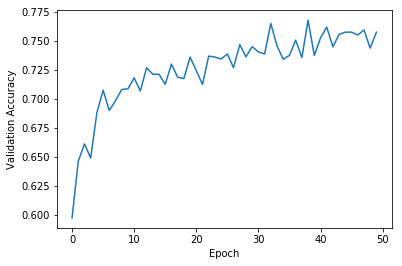

In [20]:
plt.figure()
plt.plot(range(len(history.history['val_acc'])), history.history['val_acc'])
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')

In [13]:
## Evaluate
loss_and_metrics = model.evaluate_generator(data_te, steps=50)

In [ ]:
# ### Useful
# model.save(model_path) # Save your weights and computational graph
# load_model(file_name) # loading the saved model from above
# keras.layers.Reshape()

In [14]:
loss_and_metrics

[0.1799535171687603, 0.37113656878471374, 0.743125]

In [15]:
model.metrics_names

['loss', 'mean_absolute_error', 'acc']

In [16]:
model.save('simple_nn_baseline.h5')

## Simple NN Evaluation

We split our data into 50%-50% train/test groups. The train group is further split into training (80%) and validation (20%).

At the end of the first round of training (steps of 50 per epoch; 50 epochs), the validation accuracy was 75.75%. We evaluated the fitted model on the test data, and got an accuracy of 74.3%.

The accuracies are basically identical; our model is definitely not overfit. The model's validation accuracy seems to plateau around this 75% mark. 

